# validation.ipynb
Scratch notebook to check the outputs of Go Big forward models

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
from os.path import join as pjoin


import astropy
from astropy.io import fits
import pandas as pd
import nbodykit.lab as nblab
from nbodykit import cosmology

cosmo = cosmology.Cosmology()

from tools.BOSS_FM import BOSS_angular, BOSS_veto, BOSS_redshift, thetahod_literature

In [246]:
lhid = 3
wdir = './data'
source_dir = pjoin(wdir, 'borg-quijote/latin_hypercube_HR-L3000-N384', str(lhid))

lh_lookup = pd.read_csv('latin_hypercube_params_bonus.txt', 
                        delimiter=' ', header=None, names=['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8'])
print(lh_lookup.iloc[lhid+1])

Omega_m    0.14330
Omega_b    0.06347
h          0.61270
n_s        1.15010
sigma_8    0.76990
Name: 4, dtype: float64


## simulation/rho_to_halo.py

In [247]:
Lbox=3000
rho = np.load(pjoin(source_dir, 'rho.npy'))
hpos = np.load(pjoin(source_dir, 'halo_pos.npy'))
hmass = np.load(pjoin(source_dir, 'halo_mass.npy'))
hcpos = np.load(pjoin(source_dir, 'halo_cuboid_pos.npy'))

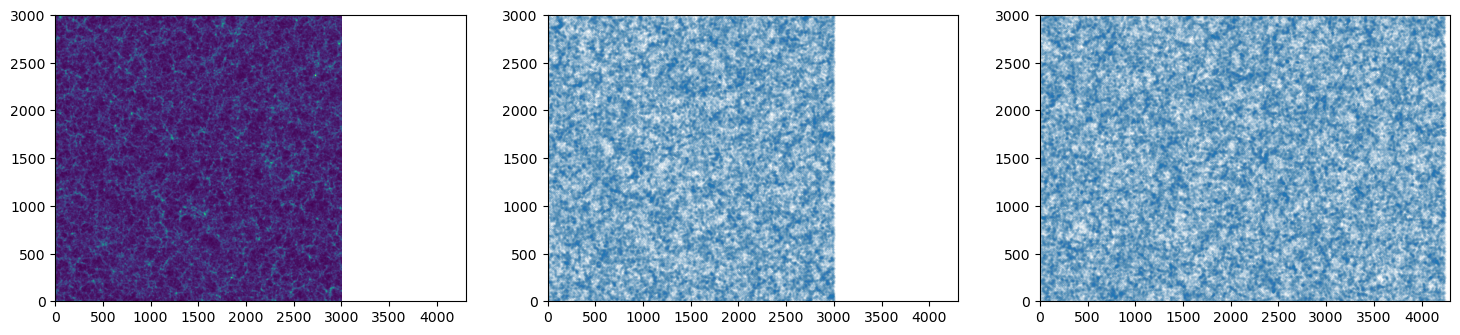

In [248]:
# plot slice
fig, axs = plt.subplots(1,3, figsize=(18,6))

axs[0].imshow(np.mean(rho[:,:,:13], axis=-1), 
              extent=[0, Lbox, 0, Lbox],
              origin='lower')
axs[0].set_xlim(0, 4.3*1e3)
axs[0].set_ylim(0, Lbox)
axs[0].set_aspect('equal')

mask = (hpos[:, -1] > 0) & (hpos[:, -1] < 100)
axs[1].scatter(hpos[mask, 0], hpos[mask, 1], s=0.1, alpha=0.1)
axs[1].set_xlim(0, 4.3*1e3)
axs[1].set_ylim(0, Lbox)
axs[1].set_aspect('equal')

mask = (hcpos[:, -1] > 0) & (hcpos[:, -1] < 100)
axs[2].scatter(hcpos[mask, 0], hcpos[mask, 1], s=0.1, alpha=0.1)
axs[2].set_xlim(0, 4.3*1e3)
axs[2].set_ylim(0, Lbox)
axs[2].set_aspect('equal')

In [223]:
from nbodykit.source.catalog import BigFileCatalog
f = BigFileCatalog('data/fastpm/fofT20B2_1.0000/LL-0.200', header='attr-v2')

mask = (f['Position']>0) & (f['Position']<3000) # idk why there are halos out here
mask = mask.all(axis=-1)
f = f[mask]

# calculate masses from particle counts
mp = float(f.attrs['M0'] * 1e10)
Ms = mp*f['Length']
f['Mass'] = Ms
f.attrs['BoxSize'] = (3000,3000,3000)

pmpos = f['Position'].compute()
pmm = f['Mass'].compute()

/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)
/data80/mattho/anaconda3/envs/nbodykit-env/lib/python3.8/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


Text(0.5, 1.0, 'PM halos')

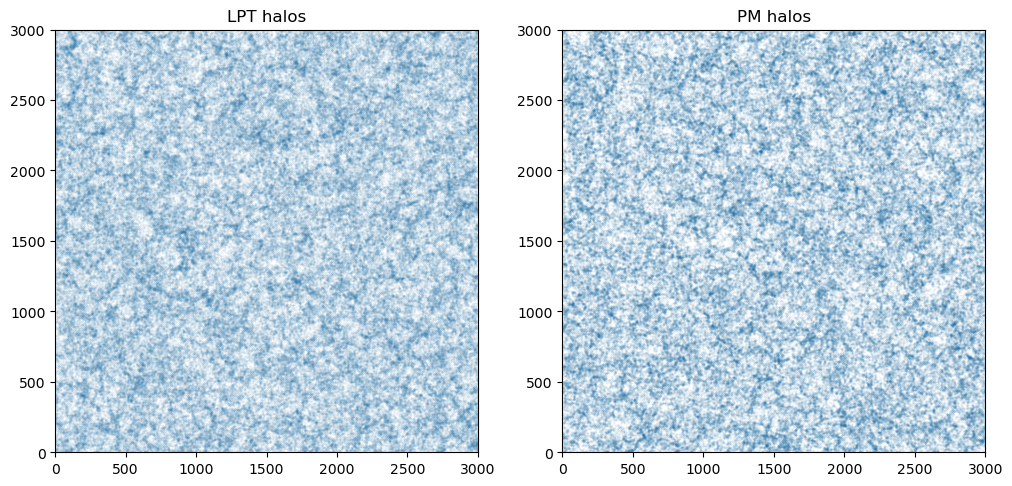

In [249]:
# compare hpos and pmpos
fig, axs = plt.subplots(1,2, figsize=(12,6))

mask = (hpos[:, -1] > 0) & (hpos[:, -1] < 100)
mask *= hmass > 13
axs[0].scatter(hpos[mask, 0], hpos[mask, 1], s=0.1, alpha=0.1)
axs[0].set_xlim(0, Lbox)
axs[0].set_ylim(0, Lbox)
axs[0].set_aspect('equal')
axs[0].set_title('LPT halos')

mask = (pmpos[:, -1] > 0) & (pmpos[:, -1] < 100)
mask *= pmm > 10**13
axs[1].scatter(pmpos[mask, 0], pmpos[mask, 1], s=0.1, alpha=0.1)
axs[1].set_xlim(0, Lbox)
axs[1].set_ylim(0, Lbox)
axs[1].set_aspect('equal')
axs[1].set_title('PM halos')


(9636634, 9749693)

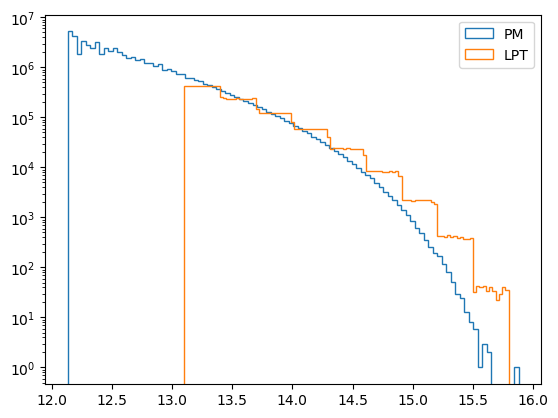

In [250]:
plt.semilogy()
plt.hist(np.log10(pmm), bins=100, histtype='step', label='PM')
plt.hist((hmass), bins=100, histtype='step', label='LPT')
plt.legend()
np.sum(pmm > 10**13), np.sum(hmass > 13)

## simulation/apply_hod.py

In [251]:
seed = 0
hod = np.load(pjoin(source_dir, 'hod', f'hod{seed}_pos.npy'))

Text(0.5, 1.0, 'HOD')

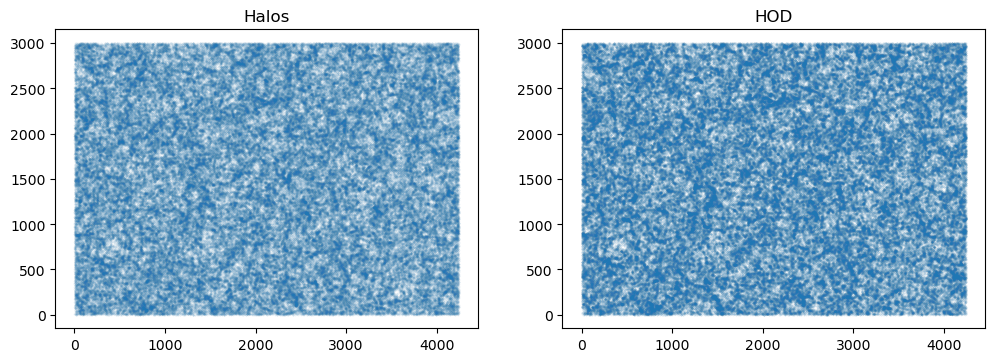

In [252]:
# plot hod comparison
fig, axs = plt.subplots(1,2, figsize=(12,6))

mask = (hcpos[:, -1] > 0) & (hcpos[:, -1] < 100)
axs[0].scatter(hcpos[mask, 0], hcpos[mask, 1], s=0.1, alpha=0.1)
axs[0].set_aspect('equal')
axs[0].set_title('Halos')

mask = (hod[:, -1] > 0) & (hod[:, -1] < 100)
axs[1].scatter(hod[mask, 0], hod[mask, 1], s=0.1, alpha=0.1)
axs[1].set_aspect('equal')
axs[1].set_title('HOD')

## simulation/apply_survey.py


In [253]:
# load simulation
rdz = np.load(pjoin(source_dir, 'obs', f'rdz{seed}.npy'))
pos = np.array(nblab.transform.SkyToCartesian(*rdz.T, cosmo=cosmo))

In [254]:
# load survey
def load_galaxies(fname, fields):
    with fits.open(fname) as hdul:
        gals = np.array([hdul[1].data[x] for x in fields]).T
        gals = pd.DataFrame(gals, columns=fields)    
    return gals
# load data
fname = 'data/obs/galaxy_DR12v5_CMASSLOWZTOT_North.fits'
fields = ['RA','DEC','Z',
          'WEIGHT_SYSTOT','WEIGHT_NOZ','WEIGHT_CP']
cmass = load_galaxies(fname, fields)
mask = BOSS_angular(cmass['RA'], cmass['DEC'])
mask *= BOSS_redshift(cmass['Z'])
cmass = cmass[mask].reset_index(drop=True)

crdz = np.stack([cmass['RA'], cmass['DEC'], cmass['Z']], axis=-1)
cpos = nblab.transform.SkyToCartesian(*crdz.T, cosmo=cosmo)
cpos = np.array(cpos.compute())

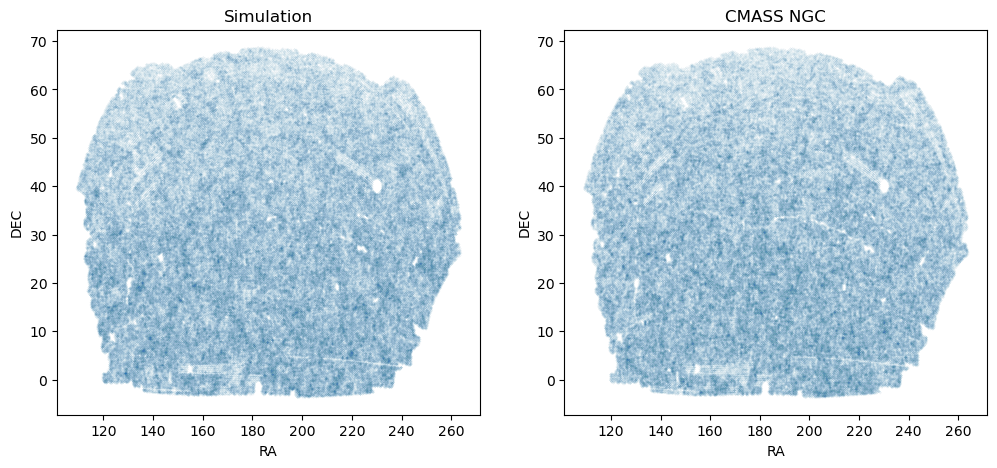

In [255]:
# plot sky-projection
fig, axs = plt.subplots(1,2, figsize=(12,5))

axs[0].scatter(rdz[:, 0], rdz[:, 1], s=0.05, alpha=0.05)
axs[0].set_title('Simulation')
axs[0].set_xlabel('RA')
axs[0].set_ylabel('DEC')

axs[1].scatter(crdz[:, 0], crdz[:, 1], s=0.05, alpha=0.05)
axs[1].set_title('CMASS NGC')
axs[1].set_xlabel('RA')
axs[1].set_ylabel('DEC')
fig.savefig('images/rdz.jpg', dpi=300, bbox_inches='tight')

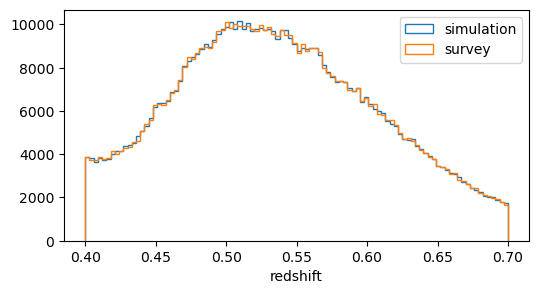

In [256]:
# plot redshift distribution on top of each other
fig, axs = plt.subplots(1,1, figsize=(6,3))

axs.hist(rdz[:, 2], bins=100, histtype='step', label='simulation')
axs.hist(crdz[:, 2], bins=100, histtype='step', label='survey')
axs.set_xlabel('redshift')
axs.legend()

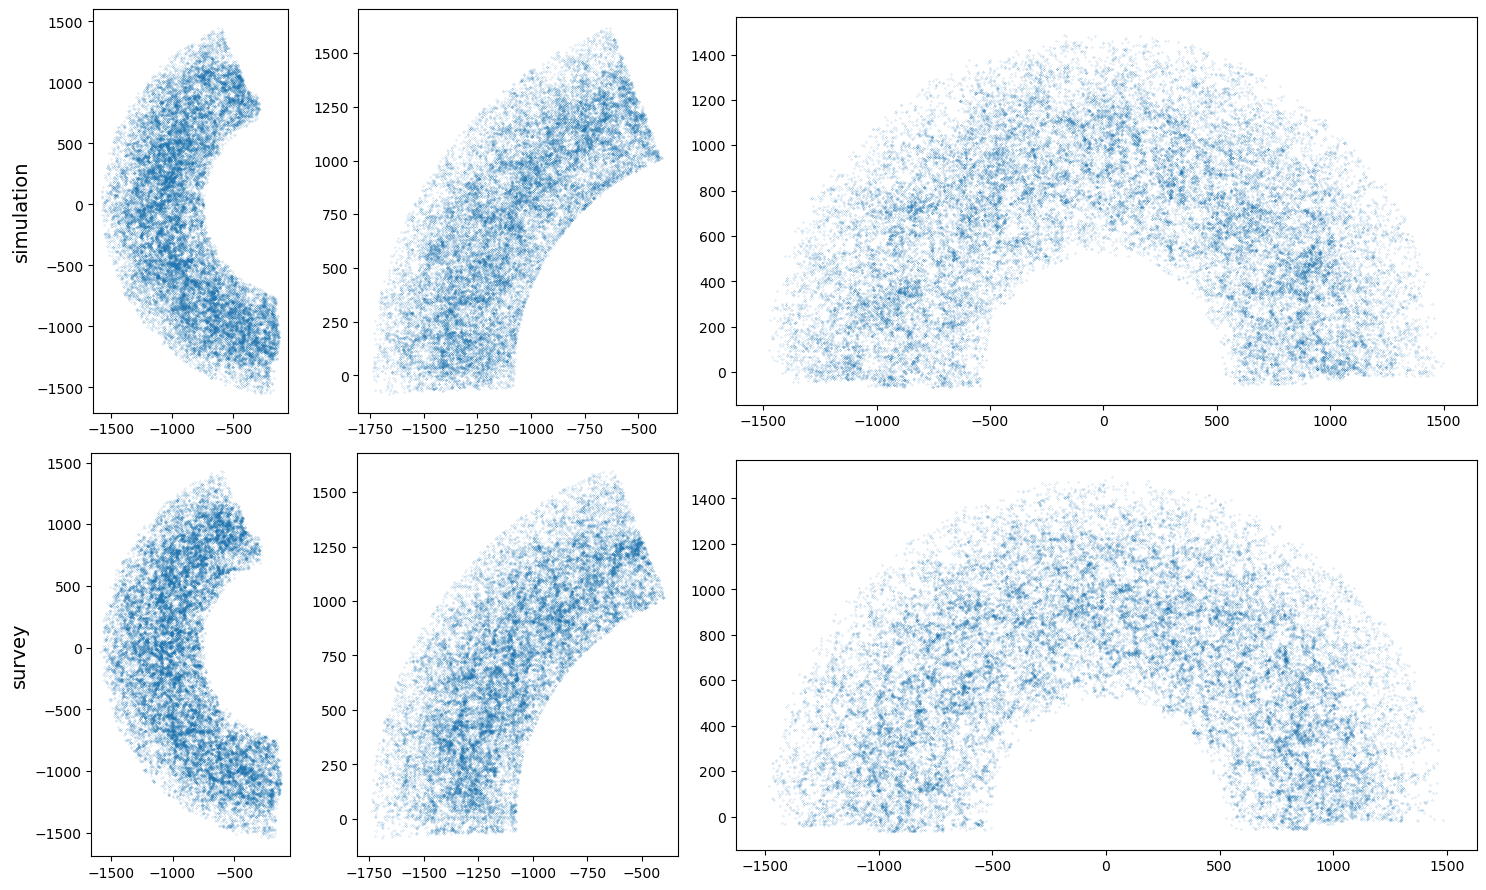

In [257]:
def slice_mask(x):
    mima = x.min(), x.max()
    dx = (mima[1] - mima[0])*0.02
    mid = np.mean(mima)
    return (x > mid - dx) & (x < mid + dx)

# plot cpos from all axes
fig, axs = plt.subplots(2,3, figsize=(18,11), gridspec_kw={'width_ratios':[1,2,3.4], 'hspace':0.1, 'wspace':0.})

for i, ipos in enumerate([pos, cpos]):
    mask = slice_mask(ipos[:, 2])
    axs[i,0].scatter(ipos[mask, 0], ipos[mask, 1], s=0.01, alpha=1)
    axs[i,0].set_aspect('equal')

    mask = slice_mask(ipos[:, 1])
    axs[i,1].scatter(ipos[mask, 0], ipos[mask, 2], s=0.01, alpha=1)
    axs[i,1].set_aspect('equal')

    mask = slice_mask(ipos[:, 0])
    axs[i,2].scatter(ipos[mask, 1], ipos[mask, 2], s=0.01, alpha=1)
    axs[i,2].set_aspect('equal')

    if i==0:
        axs[i,0].set_ylabel('simulation', fontsize=14)
    else:
        axs[i,0].set_ylabel('survey',   fontsize=14)

fig.savefig('images/pos_comparison.jpg', dpi=180, bbox_inches='tight')

In [234]:
from scipy.spatial.transform import Rotation as R
r = R.from_quat([0, 0, np.sin(np.pi/4), np.cos(np.pi/4)]).as_matrix()
hcposR = hcpos@r
hcposR -= (hcposR.max(axis=0) + hcposR.min(axis=0))/2
hcposR += [-924.42673929,  -44.04583784,  750.98510587]

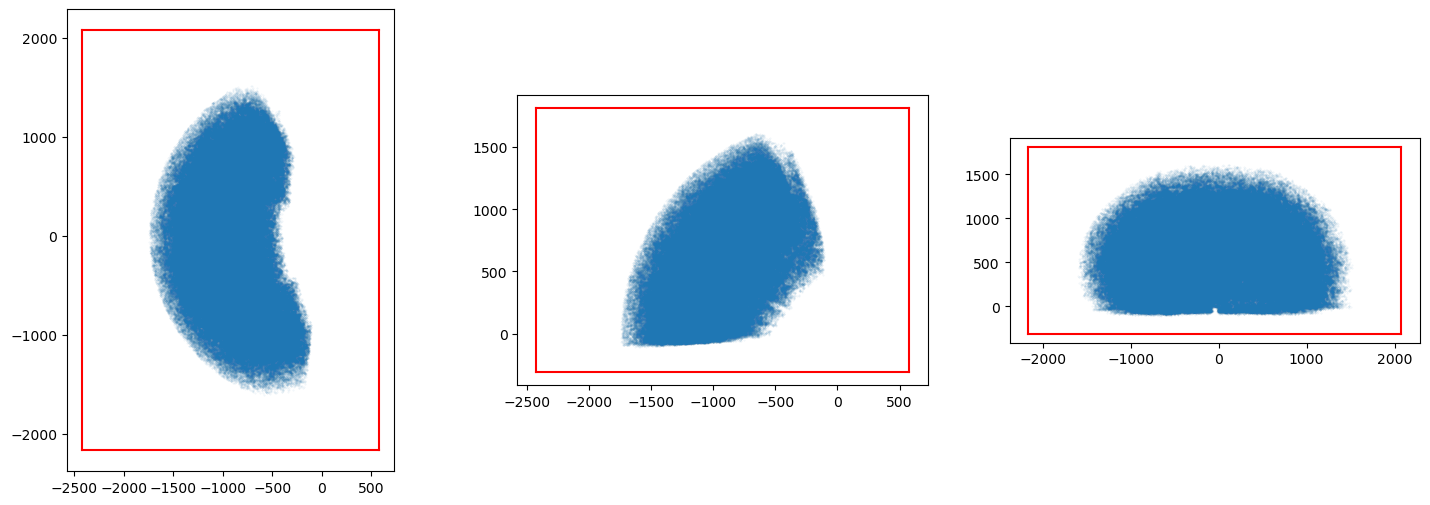

In [235]:
# plot positions from each axis
mins, maxs = hcposR.min(axis=0), hcposR.max(axis=0)
def plot_rectangle(min_x, min_y, max_x, max_y, ax, c='r'):
    ax.plot([min_x, min_x], [min_y, max_y], c=c)
    ax.plot([min_x, max_x], [min_y, min_y], c=c)
    ax.plot([max_x, max_x], [min_y, max_y], c=c)
    ax.plot([min_x, max_x], [max_y, max_y], c=c)

fig, axs = plt.subplots(1,3, figsize=(18,6))

axs[0].scatter(cpos[:, 0], cpos[:, 1], s=0.1, alpha=0.1)
plot_rectangle(mins[0], mins[1], maxs[0], maxs[1], axs[0])
axs[0].set_aspect('equal')

axs[1].scatter(cpos[:, 0], cpos[:, 2], s=0.1, alpha=0.1)
plot_rectangle(mins[0], mins[2], maxs[0], maxs[2], axs[1])
axs[1].set_aspect('equal')

axs[2].scatter(cpos[:, 1], cpos[:, 2], s=0.1, alpha=0.1)
plot_rectangle(mins[1], mins[2], maxs[1], maxs[2], axs[2])
axs[2].set_aspect('equal')

## summaries/calc_Pk_nbkit.py

In [236]:
# load simulation Pk
source_dir = pjoin(
        './data', 'borg-quijote/latin_hypercube_HR-L3000-N384',
        f'{lhid}', 'Pk')
outpath = pjoin(source_dir, f'Pk{seed}.npz')
out = np.load(outpath)
k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']

# load survey Pk
source_dir = 'data/obs'
outpath = pjoin(source_dir, 'Pk', 'Pk.npz')
out = np.load(outpath)
k_sur, p0k_sur, p2k_sur, p4k_sur = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']

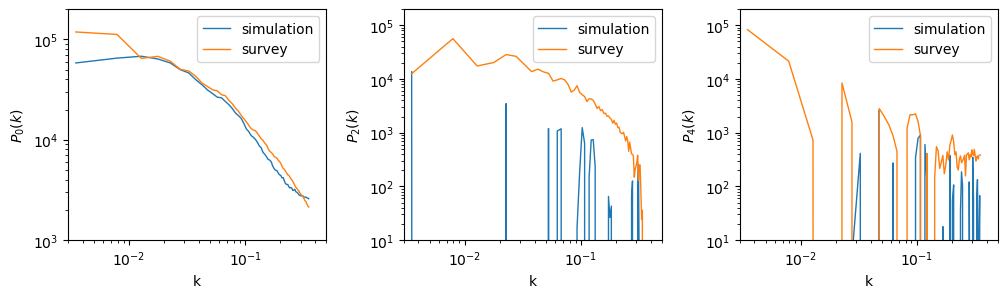

In [244]:
# plot simulation and survey Pk for a best-fit HOD model
fig, axs = plt.subplots(1,3, figsize=(12,3),
                        gridspec_kw={'wspace':0.3})

axs[0].plot(k_sim, p0k_sim*2, label='simulation', lw=1)
axs[0].plot(k_sur, p0k_sur, label='survey', lw=1)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('k')
axs[0].set_ylabel('$P_0(k)$')
axs[0].set_xlim(3e-3, 5e-1)
axs[0].set_ylim(1e3, 2*1e5)
axs[0].legend()

axs[1].plot(k_sim, p2k_sim*2, label='simulation', lw=1)
axs[1].plot(k_sur, p2k_sur, label='survey', lw=1)
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('k')
axs[1].set_ylabel('$P_2(k)$')
axs[1].set_xlim(3e-3, 5e-1)
axs[1].set_ylim(1e1, 2*1e5)
axs[1].legend()

axs[2].plot(k_sim, p4k_sim*2, label='simulation', lw=1)
axs[2].plot(k_sur, p4k_sur, label='survey', lw=1)
axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlabel('k')
axs[2].set_ylabel('$P_4(k)$')
axs[2].set_xlim(3e-3, 5e-1)
axs[2].set_ylim(1e1, 2*1e5)
axs[2].legend()

fig.savefig('images/Pk_comparison.jpg', dpi=180, bbox_inches='tight')

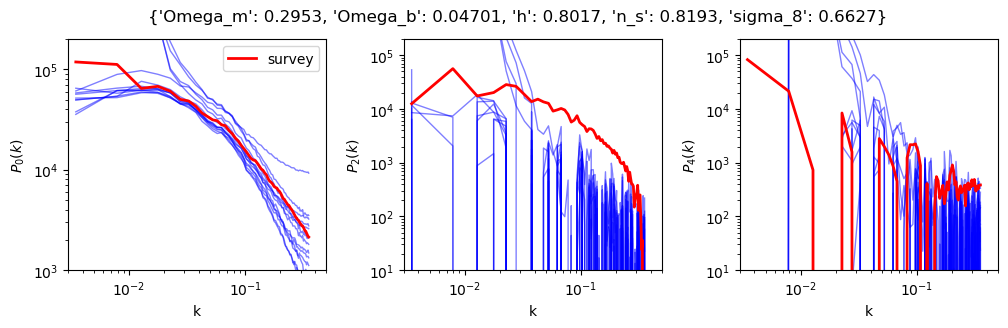

In [245]:
# plot simulation and survey Pk for various HOD models
fig, axs = plt.subplots(1,3, figsize=(12,3),
                        gridspec_kw={'wspace':0.3})


# load simulation Pk for seed in [0,50]
source_dir = pjoin(
        './data', 'borg-quijote/latin_hypercube_HR-L3000-N384',
        f'{lhid}', 'Pk')
for s in range(13): # range(40,100): # 
    outpath = pjoin(source_dir, f'Pk{s}.npz')
    out = np.load(outpath)
    k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']
    axs[0].plot(k_sim, p0k_sim*2, c='b', lw=1, alpha=0.5)
    axs[1].plot(k_sim, p2k_sim*2, c='b', lw=1, alpha=0.5)
    axs[2].plot(k_sim, p4k_sim*2, c='b', lw=1, alpha=0.5)


# axs[0].plot(k_sim, p0k_sim, label='simulation', lw=1)
axs[0].plot(k_sur, p0k_sur, label='survey', lw=2, c='r')
axs[0].loglog()
axs[0].set_xlabel('k')
axs[0].set_ylabel('$P_0(k)$')
axs[0].set_xlim(3e-3, 5e-1)
axs[0].set_ylim(1e3, 2*1e5)
axs[0].legend()

# axs[1].plot(k_sim, p2k_sim, label='simulation', lw=1)
axs[1].plot(k_sur, p2k_sur, label='survey', lw=2, c='r')
axs[1].loglog()
axs[1].set_xlabel('k')
axs[1].set_ylabel('$P_2(k)$')
axs[1].set_xlim(3e-3, 5e-1)
axs[1].set_ylim(1e1, 2*1e5)
# axs[1].legend()

# axs[2].plot(k_sim, p4k_sim, label='simulation', lw=1)
axs[2].plot(k_sur, p4k_sur, label='survey', lw=2, c='r')
axs[2].loglog()
axs[2].set_xlabel('k')
axs[2].set_ylabel('$P_4(k)$')
axs[2].set_xlim(3e-3, 5e-1)
axs[2].set_ylim(1e1, 2*1e5)
# axs[2].legend()
fig.suptitle(str(dict(lh_lookup.iloc[lhid])))
fig.savefig('images/Pk_comparison_HOD0.jpg', dpi=180, bbox_inches='tight')

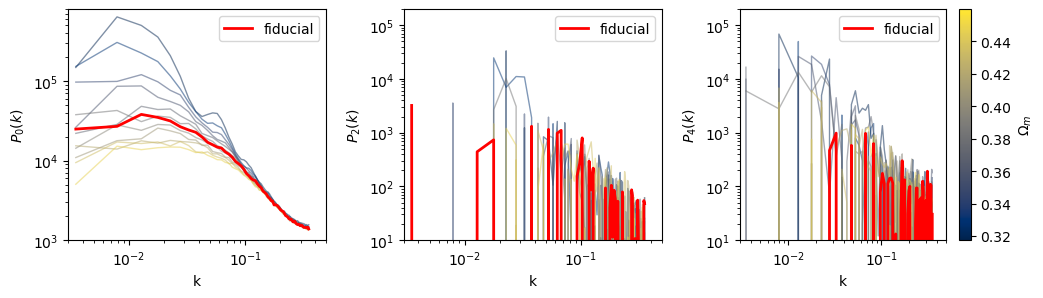

In [191]:
# plot simulation and survey Pk for different cosmologies
fig, axs = plt.subplots(1,3, figsize=(12,3),
                        gridspec_kw={'wspace':0.3})

cmap = mpl.colormaps.get_cmap('cividis')

# load simulation Pk for seed in [0,50]
lmin, lmax = 2000, 2011
for l in range(lmin, lmax):
    source_dir = pjoin(
            './data', 'borg-quijote/latin_hypercube_HR-L3000-N384',
            f'{l}', 'Pk')
    outpath = pjoin(source_dir, f'Pk0.npz')
    out = np.load(outpath)
    k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']
    color = cmap((l-lmin)/(lmax-lmin))
    axs[0].plot(k_sim, p0k_sim, c=color, lw=1, alpha=0.5)
    axs[1].plot(k_sim, p2k_sim, c=color, lw=1, alpha=0.5)
    axs[2].plot(k_sim, p4k_sim, c=color, lw=1, alpha=0.5)

l = 1999
source_dir = pjoin(
        './data', 'borg-quijote/latin_hypercube_HR-L3000-N384',
        f'{l}', 'Pk')
outpath = pjoin(source_dir, f'Pk0.npz')
out = np.load(outpath)
k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']
# axs[0].plot(k_sim, p0k_sim, label='simulation', lw=1)
axs[0].plot(k_sim, p0k_sim, label='fiducial', lw=2, c='r')
axs[0].loglog()
axs[0].set_xlabel('k')
axs[0].set_ylabel('$P_0(k)$')
axs[0].set_xlim(3e-3, 5e-1)
axs[0].set_ylim(1e3, 8*1e5)
axs[0].legend()

# axs[1].plot(k_sim, p2k_sim, label='simulation', lw=1)
axs[1].plot(k_sim, p2k_sim, label='fiducial', lw=2, c='r')
axs[1].loglog()
axs[1].set_xlabel('k')
axs[1].set_ylabel('$P_2(k)$')
axs[1].set_xlim(3e-3, 5e-1)
axs[1].set_ylim(1e1, 2*1e5)
axs[1].legend()

# axs[2].plot(k_sim, p4k_sim, label='simulation', lw=1)
axs[2].plot(k_sim, p4k_sim, label='fiducial', lw=2, c='r')
axs[2].loglog()
axs[2].set_xlabel('k')
axs[2].set_ylabel('$P_4(k)$')
axs[2].set_xlim(3e-3, 5e-1)
axs[2].set_ylim(1e1, 2*1e5)
axs[2].legend()

norm = mpl.colors.Normalize(vmin=lh_lookup.iloc[lmin,0], vmax=lh_lookup.iloc[lmax-1,0])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[2], label='$\Omega_m$')

fig.savefig('images/Pk_comparison_Om.jpg', dpi=180, bbox_inches='tight')

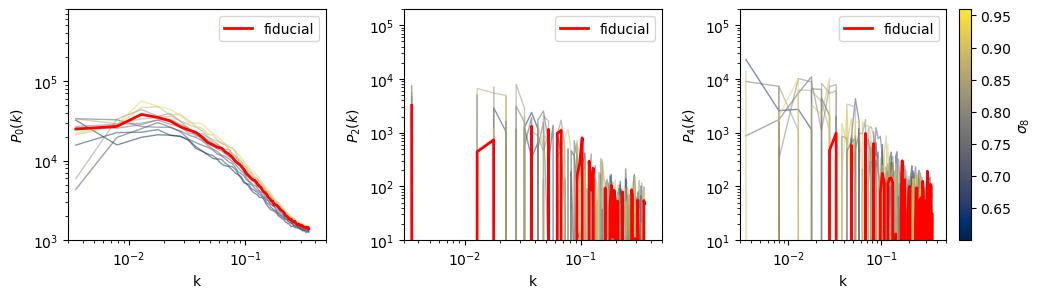

In [192]:
# plot simulation and survey Pk for different cosmologies
fig, axs = plt.subplots(1,3, figsize=(12,3),
                        gridspec_kw={'wspace':0.3})

cmap = mpl.colormaps.get_cmap('cividis')

# load simulation Pk for seed in [0,50]
lmin, lmax = 2012, 2022
for l in range(lmin, lmax):
    source_dir = pjoin(
            './data', 'borg-quijote/latin_hypercube_HR-L3000-N384',
            f'{l}', 'Pk')
    outpath = pjoin(source_dir, f'Pk0.npz')
    out = np.load(outpath)
    k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']
    color = cmap((l-lmin)/(lmax-lmin))
    axs[0].plot(k_sim, p0k_sim, c=color, lw=1, alpha=0.5)
    axs[1].plot(k_sim, p2k_sim, c=color, lw=1, alpha=0.5)
    axs[2].plot(k_sim, p4k_sim, c=color, lw=1, alpha=0.5)

l = 1999
source_dir = pjoin(
        './data', 'borg-quijote/latin_hypercube_HR-L3000-N384',
        f'{l}', 'Pk')
outpath = pjoin(source_dir, f'Pk0.npz')
out = np.load(outpath)
k_sim, p0k_sim, p2k_sim, p4k_sim = out['k_gal'], out['p0k_gal'], out['p2k_gal'], out['p4k_gal']
# axs[0].plot(k_sim, p0k_sim, label='simulation', lw=1)
axs[0].plot(k_sim, p0k_sim, label='fiducial', lw=2, c='r')
axs[0].loglog()
axs[0].set_xlabel('k')
axs[0].set_ylabel('$P_0(k)$')
axs[0].set_xlim(3e-3, 5e-1)
axs[0].set_ylim(1e3, 8*1e5)
axs[0].legend()

# axs[1].plot(k_sim, p2k_sim, label='simulation', lw=1)
axs[1].plot(k_sim, p2k_sim, label='fiducial', lw=2, c='r')
axs[1].loglog()
axs[1].set_xlabel('k')
axs[1].set_ylabel('$P_2(k)$')
axs[1].set_xlim(3e-3, 5e-1)
axs[1].set_ylim(1e1, 2*1e5)
axs[1].legend()

# axs[2].plot(k_sim, p4k_sim, label='simulation', lw=1)
axs[2].plot(k_sim, p4k_sim, label='fiducial', lw=2, c='r')
axs[2].loglog()
axs[2].set_xlabel('k')
axs[2].set_ylabel('$P_4(k)$')
axs[2].set_xlim(3e-3, 5e-1)
axs[2].set_ylim(1e1, 2*1e5)
axs[2].legend()

norm = mpl.colors.Normalize(vmin=lh_lookup.iloc[lmin,-1], vmax=lh_lookup.iloc[lmax-1,-1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs[2], label='$\sigma_8$')

fig.savefig('images/Pk_comparison_s8.jpg', dpi=180, bbox_inches='tight')